In [1]:
# Instalar la libreria si no esta instalada
if (!requireNamespace("mlbench", quietly = TRUE)) {
    install.packages("mlbench")
}

# Cargar la libreria
library(mlbench)

# Cargar el conjunto de datos
data("PimaIndiansDiabetes2")

# Número de filas en el dataset original
total_rows_original <- nrow(PimaIndiansDiabetes2)
print(paste("Número total de filas en el dataset original:", total_rows_original))

# Eliminar filas con valores NA
pima_data <- na.omit(PimaIndiansDiabetes2)

# Número de filas después de eliminar NA
total_rows_clean <- nrow(pima_data)
print(paste("Número total de filas después de eliminar filas con NA:", total_rows_clean))

pima_data <- pima_data[, c("glucose", "mass", "diabetes")]

# Ver las primeras filas del conjunto de datos
head(pima_data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "Número total de filas en el dataset original: 768"
[1] "Número total de filas después de eliminar filas con NA: 392"


,glucose,mass,diabetes
,<dbl>,<dbl>,<fct>
4,89,28.1,neg
5,137,43.1,pos
7,78,31.0,pos
9,197,30.5,pos
14,189,30.1,pos
15,166,25.8,pos


Para hacer clustering no hace falta dividir los datos en train y test, ya que es un modelo de aprendizaje no supervisado. Es decir, el objetivo no es hacer predicciones, sino encontrar patrones subyacentes.

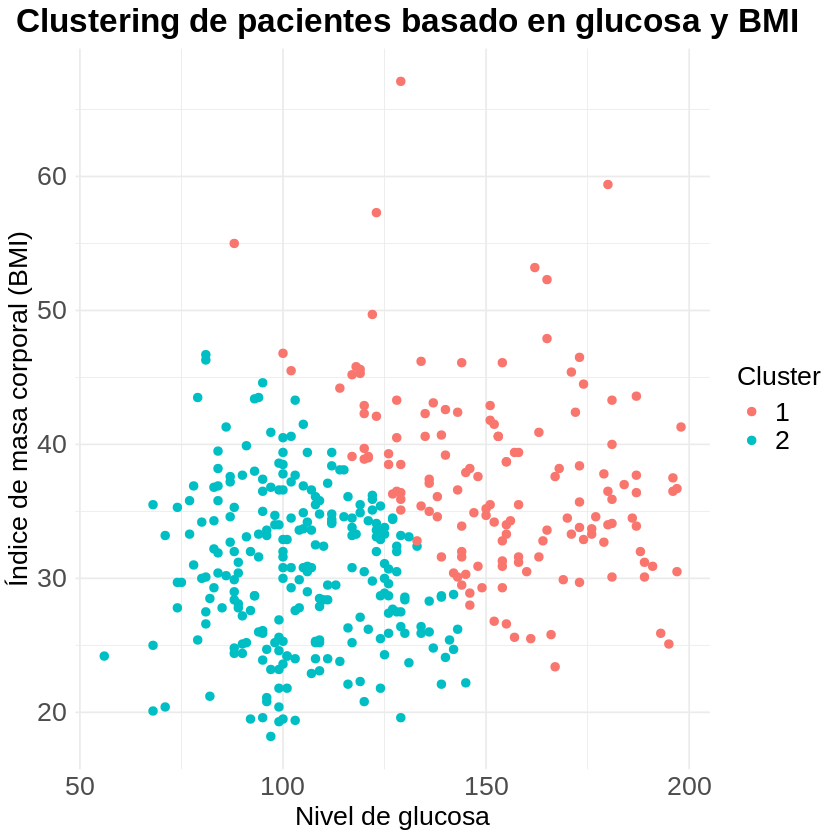

In [2]:
# Cargar librerías necesarias
library(ggplot2)

# Seleccionar las variables de interés
clustering_data <- scale(pima_data[, c("glucose", "mass")])  # Escalar los datos

# Aplicar K-means
set.seed(610014)  # Asegurar reproducibilidad
kmeans_result <- kmeans(clustering_data, centers = 2, nstart = 20)

# Añadir resultados al dataset original
pima_data$Cluster <- as.factor(kmeans_result$cluster)

# Visualización del clustering con ajustes en el tamaño del texto
ggplot(pima_data, aes(x = glucose, y = mass, color = Cluster)) +
  geom_point(size = 2) +
  labs(
    title = "Clustering de pacientes basado en glucosa y BMI",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (BMI)",
    color = "Cluster"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.4),
    axis.title = element_text(size = 16),                # Tamaño de los títulos de los ejes
    axis.text = element_text(size = 16),                 # Tamaño de los valores en los ejes
    legend.title = element_text(size = 16),              # Tamaño del título de la leyenda
    legend.text = element_text(size = 16)                # Tamaño del texto de la leyenda
  )

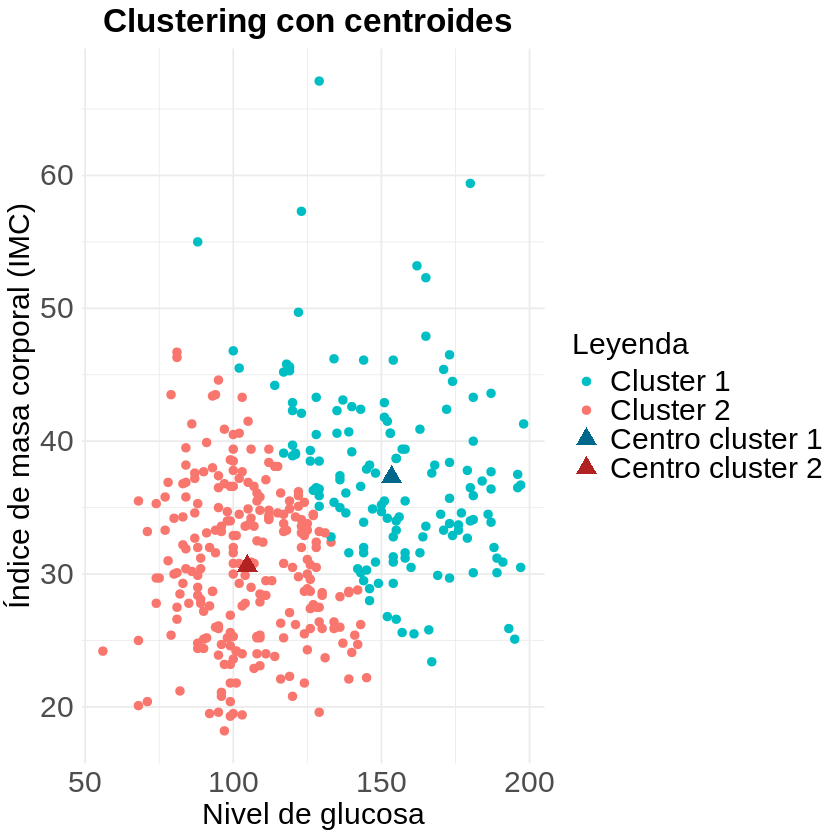

In [4]:
# Calcular los centros de los clusters (escalados)
cluster_centers <- as.data.frame(kmeans_result$centers)
names(cluster_centers) <- c("glucose", "mass")

# Desescalar los centros a la escala original
original_means <- colMeans(pima_data[, c("glucose", "mass")])  # Medias originales
original_sds <- apply(pima_data[, c("glucose", "mass")], 2, sd)  # Desviaciones estándar originales

cluster_centers_original <- data.frame(
  glucose = cluster_centers$glucose * original_sds["glucose"] + original_means["glucose"],
  mass = cluster_centers$mass * original_sds["mass"] + original_means["mass"],
  Cluster = factor(c("Centro cluster 1", "Centro cluster 2"))
)

# Crear colores para los clusters y sus centros
point_colors <- c("1" = "#00BFC4", "2" = "#F8766D")  # Colores de puntos (rojo y turquesa)
center_colors <- c("Centro cluster 1" = "#00688B", "Centro cluster 2" = "#B22222")  # Más oscuros

# Gráfico final con ajustes de tamaño de texto
ggplot() +
  # Puntos de datos
  geom_point(data = pima_data, aes(x = glucose, y = mass, color = Cluster), size = 2) +
  # Centros de clusters
  geom_point(data = cluster_centers_original, aes(x = glucose, y = mass, color = Cluster),
             shape = 17, size = 4) +
  # Configuración de colores y leyenda
  scale_color_manual(
    values = c(point_colors, center_colors),
    breaks = c("1", "2", "Centro cluster 1", "Centro cluster 2"),
    labels = c("Cluster 1", "Cluster 2", "Centro cluster 1", "Centro cluster 2")
  ) +
  labs(
    title = "Clustering con centroides",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)",
    color = "Leyenda"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.4),  # Título
    axis.title = element_text(size = 18),                             # Etiquetas de ejes
    axis.text = element_text(size = 18),                              # Texto de ejes
    legend.title = element_text(size = 18),                           # Título de la leyenda
    legend.text = element_text(size = 18)                             # Texto de la leyenda
  )

In [5]:
# Fijar semilla para reproducibilidad
set.seed(61001)

# Índices para dividir los datos
train_indices <- sample(1:nrow(pima_data), 0.8 * nrow(pima_data))

# Conjuntos de entrenamiento y prueba
train_data <- pima_data[train_indices, ]
test_data <- pima_data[-train_indices, ]


# Convertir la variable diabetes a binaria en ambos conjuntos
train_data$diabetes <- ifelse(train_data$diabetes == "pos", 1, 0)
test_data$diabetes <- ifelse(test_data$diabetes == "pos", 1, 0)

# Seleccionar las columnas de interés
#train_data <- train_data[, c("glucose", "mass", "diabetes")]
#test_data <- test_data[, c("glucose", "mass", "diabetes")]

# Verificar los cambios
head(train_data)
head(test_data)

,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
487,139,40.7,0,1
303,77,35.8,0,2
509,84,30.4,0,2
470,154,46.1,0,1
365,147,34.9,0,1
207,196,37.5,1,1


,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
5,137,43.1,1,1
14,189,30.1,1,1
17,118,45.8,1,1
19,103,43.3,0,2
20,115,34.6,1,2
21,126,39.3,0,1


In [6]:
# Escalar las variables predictoras en el conjunto de entrenamiento y guardar estadísticas
glucose_scaled <- scale(train_data$glucose)
mass_scaled <- scale(train_data$mass)

# Asignar los valores escalados al conjunto de entrenamiento
train_data$glucose <- as.numeric(glucose_scaled)
train_data$mass <- as.numeric(mass_scaled)

# Guardar las estadísticas de escalado
glucose_mean <- attr(glucose_scaled, "scaled:center")
glucose_sd <- attr(glucose_scaled, "scaled:scale")
mass_mean <- attr(mass_scaled, "scaled:center")
mass_sd <- attr(mass_scaled, "scaled:scale")

# Escalar las mismas columnas en el conjunto de prueba usando las estadísticas del entrenamiento
test_data$glucose <- as.numeric((test_data$glucose - glucose_mean) / glucose_sd)
test_data$mass <- as.numeric((test_data$mass - mass_mean) / mass_sd)

# Verificar los cambios
head(train_data)
head(test_data)

,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
487,0.5515935,1.0532713,0,1
303,-1.4631296,0.3725287,0,2
509,-1.2356609,-0.3776774,0,2
470,1.0390266,1.8034775,0,1
365,0.8115578,0.2474943,0,1
207,2.4038390,0.6087047,1,1


,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
5,0.4866025,1.3866963,1,1
14,2.1763703,-0.4193556,1,1
17,-0.1308127,1.7617993,1,1
19,-0.6182457,1.4144817,0,2
20,-0.2282993,0.2058162,1,2
21,0.1291516,0.8587734,0,1


Implementación del modelo de regresión logísitca.

In [7]:
# Ajustar el modelo de regresión logística en el conjunto de entrenamiento
logistic_model <- glm(diabetes ~ glucose + mass, data = train_data, family = binomial)

# Resumen del modelo (coeficientes y significancia)
cat("Resumen del modelo de regresión logística:\n")
summary(logistic_model)

# Predicciones en el conjunto de prueba
test_data$prob <- predict(logistic_model, newdata = test_data, type = "response")  # Probabilidades predichas
test_data$pred <- ifelse(test_data$prob > 0.5, 1, 0)                              # Clasificación basada en 0.5

# Calcular precisión del modelo en el conjunto de prueba
accuracy <- mean(test_data$diabetes == test_data$pred)
accuracy_logistic <- accuracy
cat("Precisión del modelo en el conjunto de prueba:", round(accuracy * 100, 2), "%\n")

Resumen del modelo de regresión logística:



Call:
glm(formula = diabetes ~ glucose + mass, family = binomial, data = train_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.8803     0.1479  -5.950 2.67e-09 ***
glucose       1.2698     0.1677   7.571 3.71e-14 ***
mass          0.4540     0.1509   3.008  0.00263 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 400.73  on 312  degrees of freedom
Residual deviance: 301.35  on 310  degrees of freedom
AIC: 307.35

Number of Fisher Scoring iterations: 4


Precisión del modelo en el conjunto de prueba: 79.75 %


In [9]:
install.packages("patchwork")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



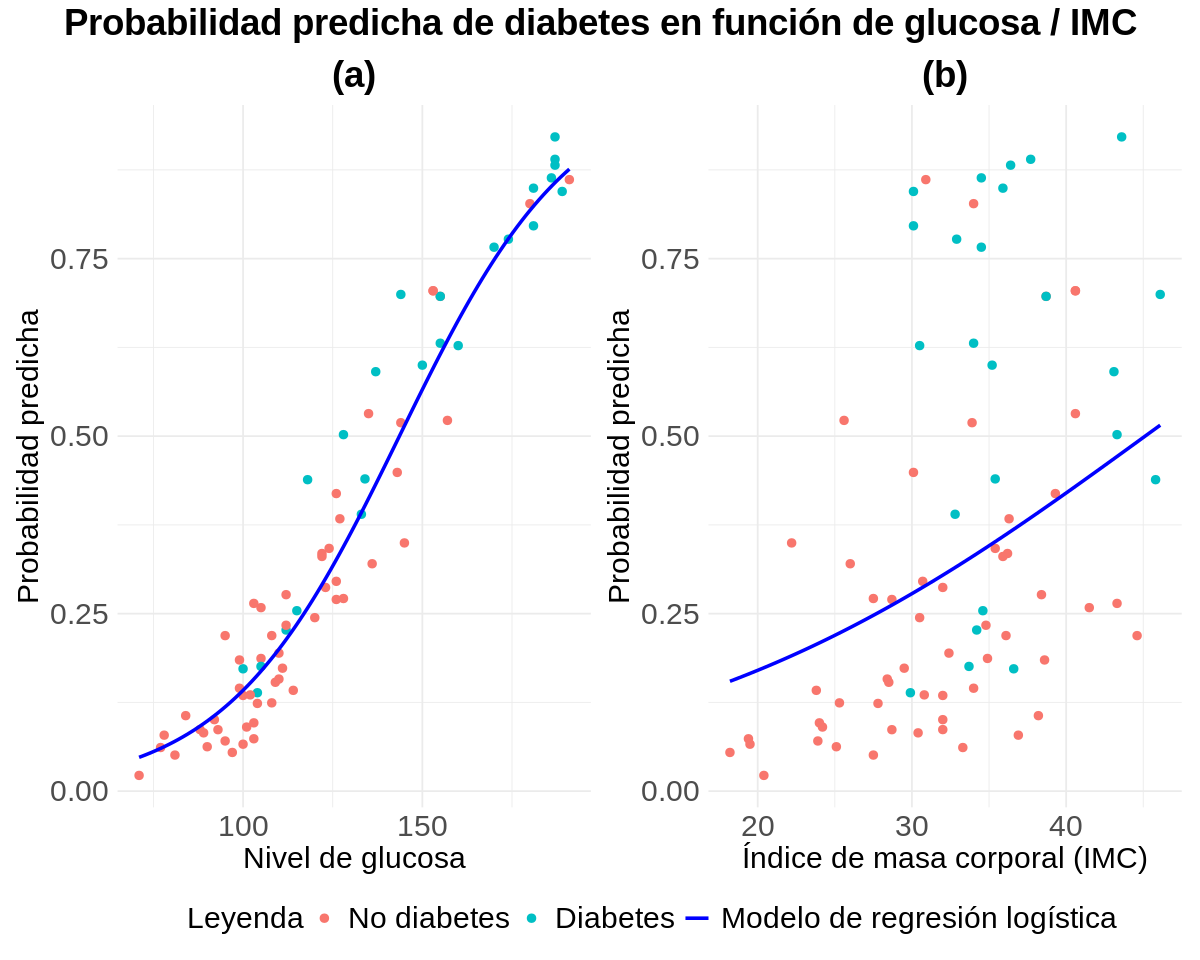

In [17]:
library(ggplot2)
library(patchwork)

# Asegurar que la figura tenga suficiente espacio en Jupyter Notebook o Google Colab
options(repr.plot.width=10, repr.plot.height=8)  # Ajustar ancho y alto del gráfico

# Crear datos para la curva sigmoide (glucose)
curve_data <- data.frame(
  glucose = seq(min(test_data$glucose), max(test_data$glucose), length.out = 100),
  mass = mean(test_data$mass)  # Mantener 'mass' constante en su promedio
)
curve_data$prob <- predict(logistic_model, newdata = curve_data, type = "response")  # Predicciones para la sigmoide
curve_data$glucose_original <- (curve_data$glucose * glucose_sd) + glucose_mean  # Desescalar glucose

# Desescalar glucose en test_data
test_data$glucose_original <- (test_data$glucose * glucose_sd) + glucose_mean

# Gráfico 1: Probabilidad frente a glucosa
plot_glucose <- ggplot(test_data, aes(x = glucose_original, y = prob, color = as.factor(diabetes))) +
  geom_point(size = 2) +
  geom_line(data = curve_data, aes(x = glucose_original, y = prob, color = "Modelo de regresión logística"), size = 1) +
  labs(
    x = "Nivel de glucosa",
    y = "Probabilidad predicha",
    color = "Leyenda"
  ) +
  scale_color_manual(
    values = c("0" = "#F8766D", "1" = "#00BFC4", "Modelo de regresión logística" = "blue"),
    labels = c("0" = "No diabetes", "1" = "Diabetes", "Modelo de regresión logística" = "Modelo de regresión logística")
  ) +
  theme_minimal() +
  ggtitle("(a)") +  # Etiqueta (a)
  theme(
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5),  # Título del gráfico
    axis.title = element_text(size = 18),                             # Títulos de los ejes
    axis.text = element_text(size = 18),                              # Texto de los valores en los ejes
    legend.title = element_text(size = 18),                           # Título de la leyenda
    legend.text = element_text(size = 18)                             # Texto de la leyenda
  )

# Crear datos para la curva sigmoide basada en mass
curve_data_mass <- data.frame(
  glucose = mean(test_data$glucose),  # Mantener 'glucose' constante en su promedio
  mass = seq(min(test_data$mass), max(test_data$mass), length.out = 100)
)
curve_data_mass$prob <- predict(logistic_model, newdata = curve_data_mass, type = "response")
curve_data_mass$mass_original <- (curve_data_mass$mass * mass_sd) + mass_mean  # Desescalar mass

# Gráfico 2: Probabilidad frente a mass
plot_mass <- ggplot(test_data, aes(x = (mass * mass_sd) + mass_mean, y = prob, color = as.factor(diabetes))) +
  geom_point(size = 2) +
  geom_line(data = curve_data_mass, aes(x = mass_original, y = prob, color = "Modelo de regresión logística"), size = 1) +
  labs(
    x = "Índice de masa corporal (IMC)",
    y = "Probabilidad predicha",
    color = "Leyenda"
  ) +
  scale_color_manual(
    values = c("0" = "#F8766D", "1" = "#00BFC4", "Modelo de regresión logística" = "blue"),
    labels = c("0" = "No diabetes", "1" = "Diabetes", "Modelo de regresión logística" = "Modelo de regresión logística")
  ) +
  theme_minimal() +
  ggtitle("(b)") +  # Etiqueta (b)
  theme(
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5),  # Título del gráfico
    axis.title = element_text(size = 18),                             # Títulos de los ejes
    axis.text = element_text(size = 18),                              # Texto de los valores en los ejes
    legend.title = element_text(size = 18),                           # Título de la leyenda
    legend.text = element_text(size = 18)                             # Texto de la leyenda
  )

# Combinar ambos gráficos en una sola figura
combined_plot <- plot_glucose + plot_mass +
  plot_layout(guides = "collect") &
  plot_annotation(
    title = "Probabilidad predicha de diabetes en función de glucosa / IMC",
    theme = theme(
      plot.title = element_text(size = 22, face = "bold", hjust = 0.5)  # Título de la figura combinada
    )
  ) &
  theme(
    legend.position = "bottom",      # Colocar la leyenda en la parte inferior
    legend.title = element_text(size = 18),  # Ajustar tamaño del título de la leyenda
    legend.text = element_text(size = 18)    # Ajustar tamaño del texto de la leyenda
  )

# Mostrar el gráfico combinado
print(combined_plot)

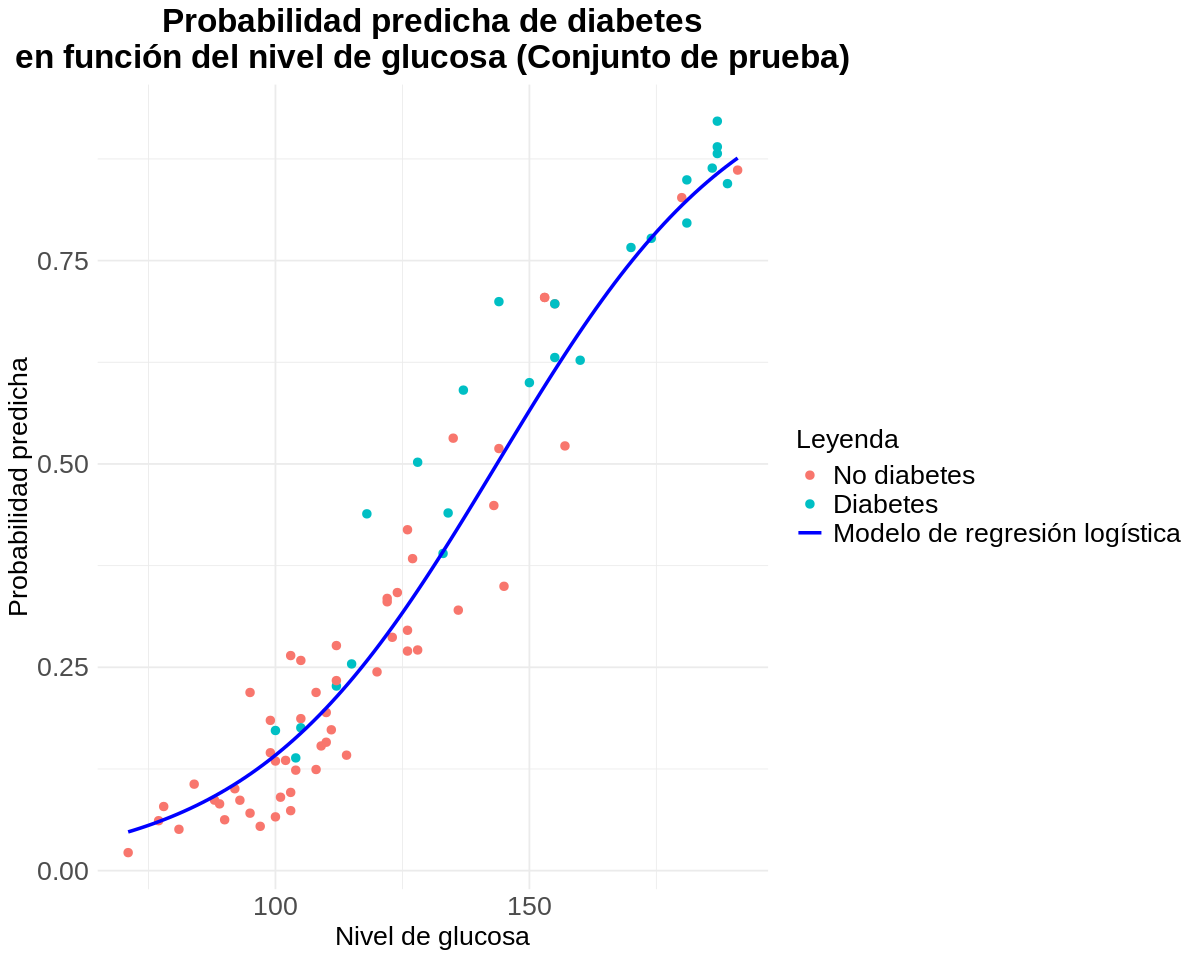

In [18]:
# Crear datos para la curva sigmoide
curve_data <- data.frame(
  glucose = seq(min(test_data$glucose), max(test_data$glucose), length.out = 100),
  mass = mean(test_data$mass)  # Mantener 'mass' constante en su promedio
)
curve_data$prob <- predict(logistic_model, newdata = curve_data, type = "response")  # Predicciones para la sigmoide

# Desescalar glucose para la curva sigmoide
curve_data$glucose_original <- (curve_data$glucose * glucose_sd) + glucose_mean

# Desescalar glucose en test_data para el gráfico
test_data$glucose_original <- (test_data$glucose * glucose_sd) + glucose_mean

# Gráfico: Probabilidad predicha frente a glucosa (escala original)
ggplot(test_data, aes(x = glucose_original, y = prob, color = as.factor(diabetes))) +
  geom_point(size = 2) +  # Puntos del conjunto de prueba
  geom_line(data = curve_data, aes(x = glucose_original, y = prob, color = "Modelo de regresión logística"), size = 1) +
  labs(
    title = "Probabilidad predicha de diabetes\nen función del nivel de glucosa (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Probabilidad predicha",
    color = "Leyenda"
  ) +
  scale_color_manual(
    values = c("0" = "#F8766D", "1" = "#00BFC4", "Modelo de regresión logística" = "blue"),
    labels = c("0" = "No diabetes", "1" = "Diabetes", "Modelo de regresión logística" = "Modelo de regresión logística")
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),  # Tamaño y posición del título
    axis.title = element_text(size = 16),                             # Tamaño de las etiquetas de los ejes
    axis.text = element_text(size = 16),                              # Tamaño de los valores en los ejes
    legend.title = element_text(size = 16),                           # Tamaño del título de la leyenda
    legend.text = element_text(size = 16)                             # Tamaño del texto de la leyenda
  )

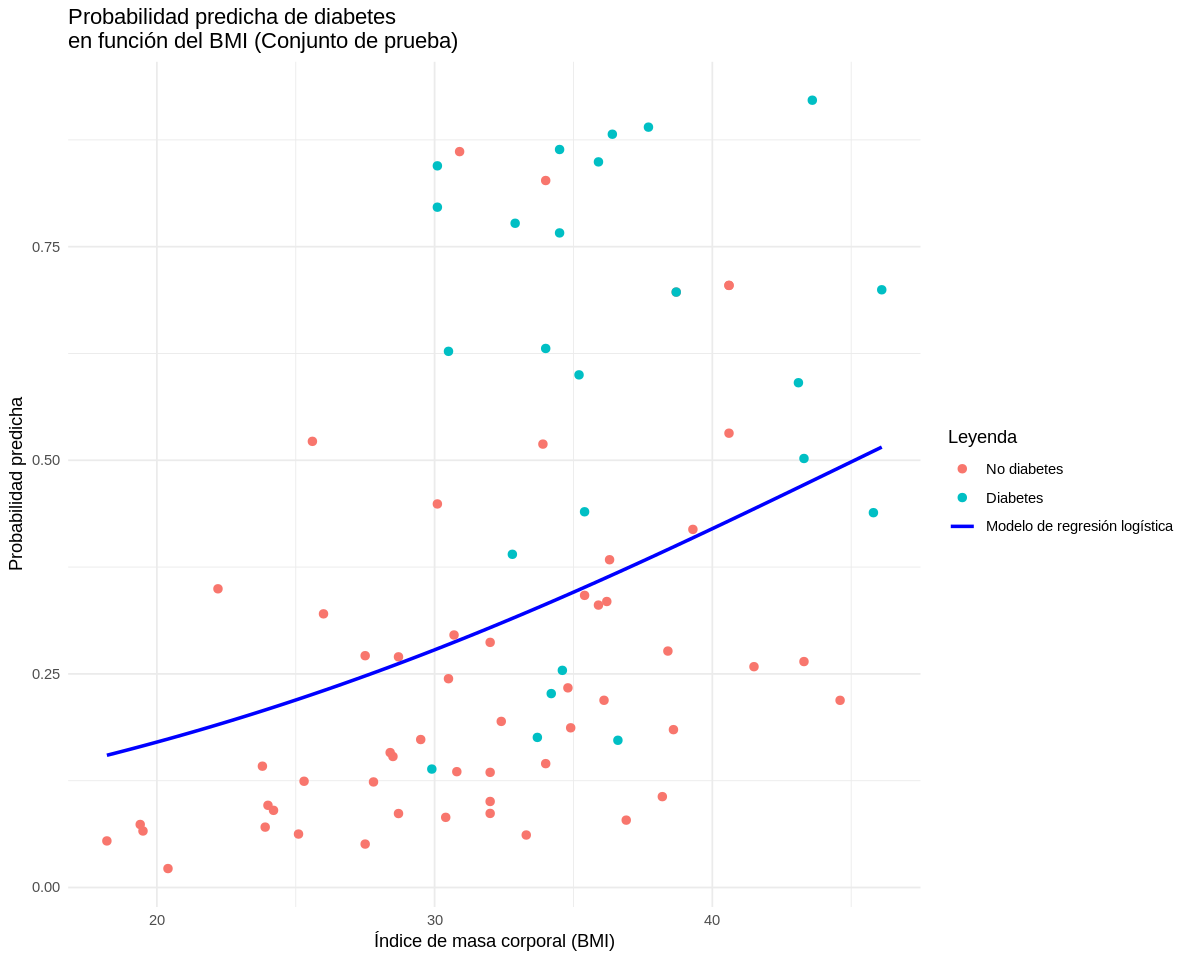

In [19]:
# Crear datos para la curva sigmoide basada en mass
curve_data_mass <- data.frame(
  glucose = mean(test_data$glucose),  # Mantener 'glucose' constante en su promedio
  mass = seq(min(test_data$mass), max(test_data$mass), length.out = 100)
)
curve_data_mass$prob <- predict(logistic_model, newdata = curve_data_mass, type = "response")

# Desescalar mass para la curva sigmoide
curve_data_mass$mass_original <- (curve_data_mass$mass * mass_sd) + mass_mean

# Gráfico: Probabilidad predicha frente a mass (escala original)
ggplot(test_data, aes(x = (mass * mass_sd) + mass_mean, y = prob, color = as.factor(diabetes))) +
  geom_point(size = 2) +  # Puntos del conjunto de prueba
  geom_line(data = curve_data_mass, aes(x = mass_original, y = prob, color = "Modelo de regresión logística"), size = 1) +
  labs(
    title = "Probabilidad predicha de diabetes\nen función del BMI (Conjunto de prueba)",
    x = "Índice de masa corporal (BMI)",
    y = "Probabilidad predicha",
    color = "Leyenda"
  ) +
  scale_color_manual(
    values = c("0" = "#F8766D", "1" = "#00BFC4", "Modelo de regresión logística" = "blue"),
    labels = c("0" = "No diabetes", "1" = "Diabetes", "Modelo de regresión logística" = "Modelo de regresión logística")
  ) +
  theme_minimal()

Esta siguiente celda no hace falta incluirla en el Anexo, solo grafica la manera antigua de mostrar la frontera de decisión.

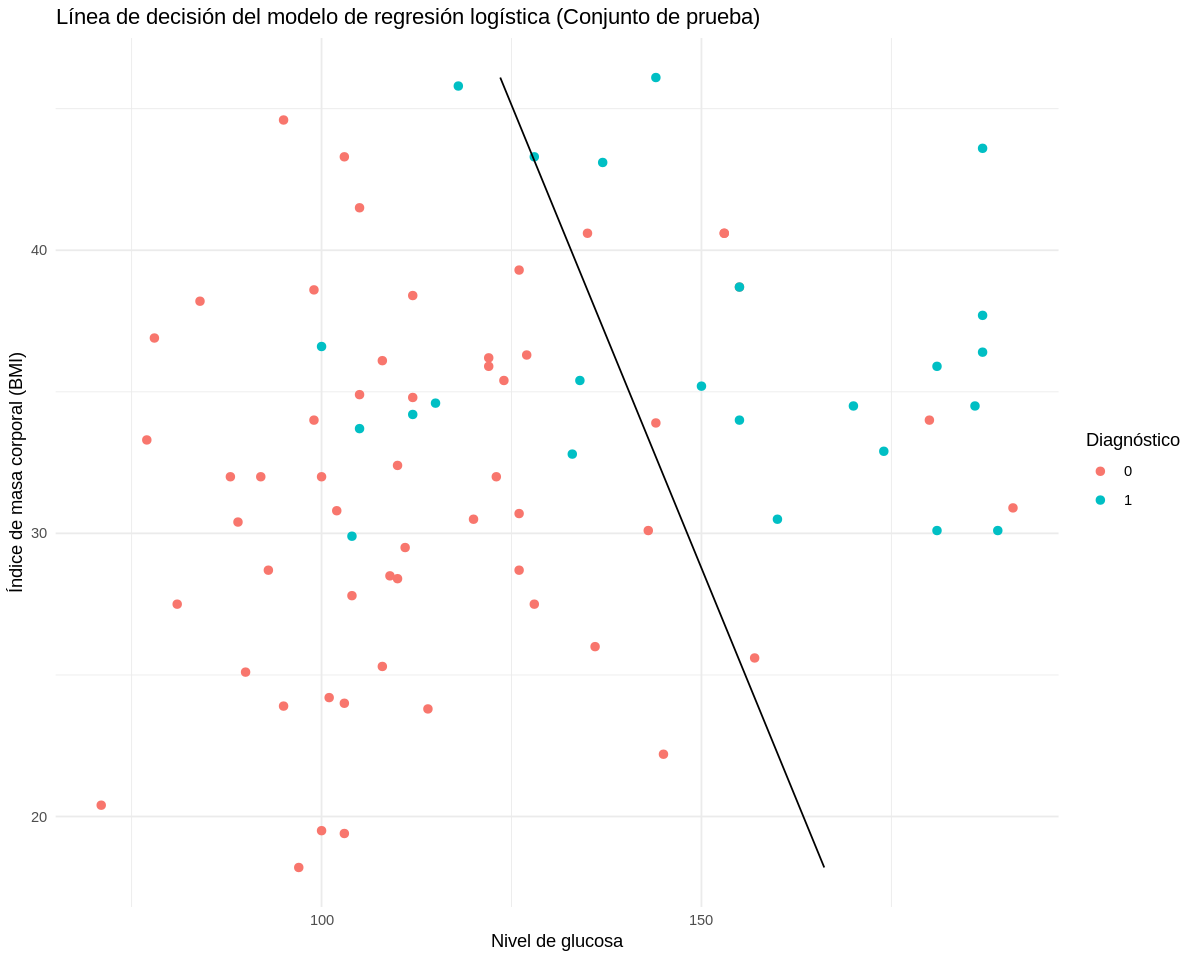

In [20]:
# Crear una malla para graficar la línea de decisión
grid <- expand.grid(
  glucose = seq(min(test_data$glucose), max(test_data$glucose), length = 100),  # Rango escalado de glucosa
  mass = seq(min(test_data$mass), max(test_data$mass), length = 100)            # Rango escalado de BMI
)

# Calcular las probabilidades para la malla
grid$prob <- predict(logistic_model, newdata = grid, type = "response")
grid$pred <- ifelse(grid$prob > 0.5, 1, 0)  # Clasificación según el modelo

# Desescalar las columnas glucose y mass en la malla
grid$glucose_original <- (grid$glucose * glucose_sd) + glucose_mean
grid$mass_original <- (grid$mass * mass_sd) + mass_mean

# Desescalar las columnas glucose y mass en test_data
test_data$glucose_original <- (test_data$glucose * glucose_sd) + glucose_mean
test_data$mass_original <- (test_data$mass * mass_sd) + mass_mean

# Visualizar los datos del conjunto de prueba y la línea de decisión
library(ggplot2)
ggplot(test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes))) +
  geom_point(size = 2) +  # Puntos del conjunto de prueba
  geom_contour(data = grid, aes(x = glucose_original, y = mass_original, z = prob), breaks = 0.5, color = "black") +
  labs(
    title = "Línea de decisión del modelo de regresión logística (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (BMI)",
    color = "Diagnóstico"
  ) +
  theme_minimal()

Esta es la manera nueva de presentar la frontera de decisión, incluir esta en el Anexo.

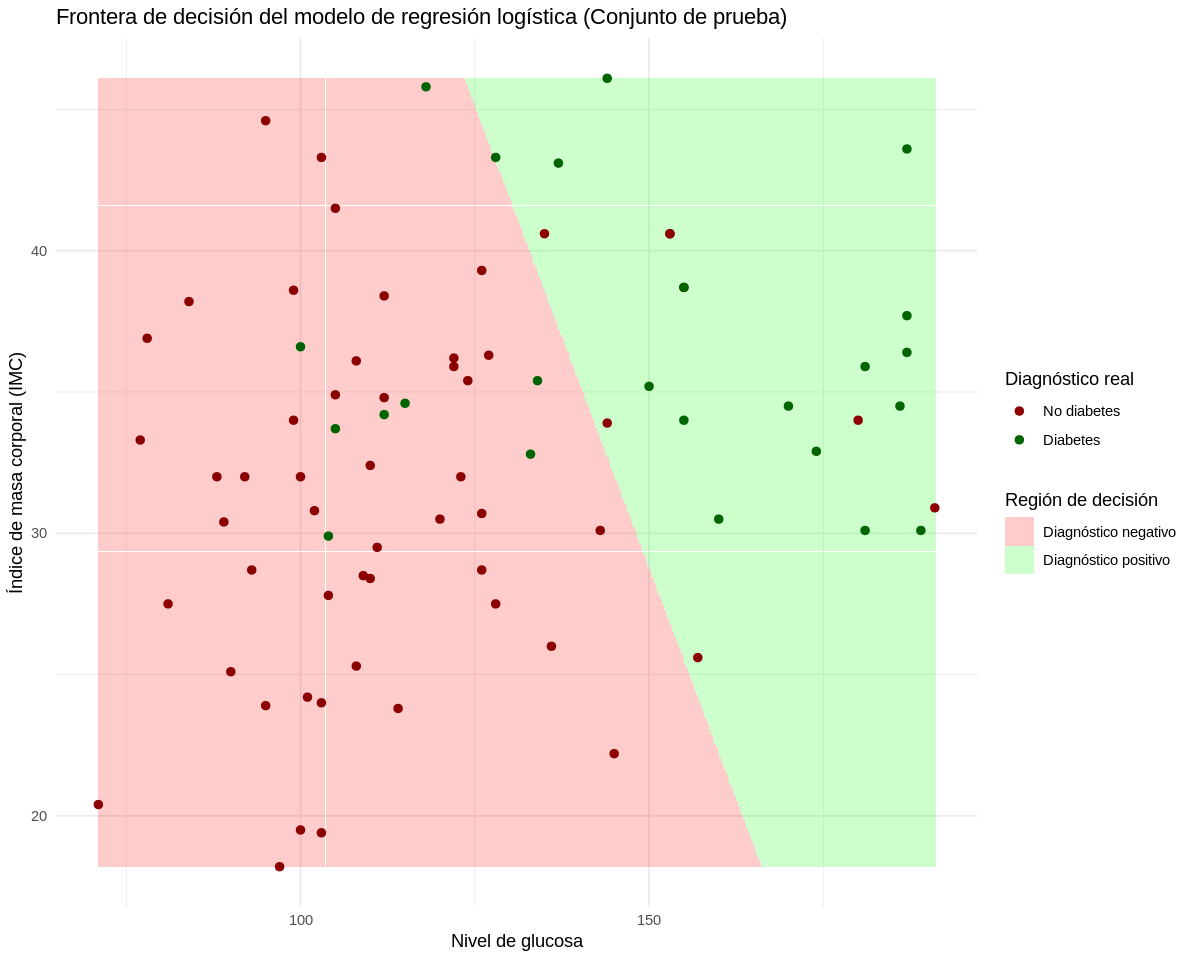

In [21]:
# Ampliar los rangos de la malla para incluir todos los puntos de test_data
glucose_range <- range(test_data$glucose_original)
mass_range <- range(test_data$mass_original)

grid <- expand.grid(
  glucose_original = seq(glucose_range[1], glucose_range[2], length.out = 500),
  mass_original = seq(mass_range[1], mass_range[2], length.out = 500)
)

# Escalar nuevamente las columnas glucose y mass en la malla para hacer predicciones
grid$glucose <- (grid$glucose_original - glucose_mean) / glucose_sd
grid$mass <- (grid$mass_original - mass_mean) / mass_sd

# Calcular las probabilidades para la malla
grid$prob <- predict(logistic_model, newdata = grid, type = "response")
grid$pred <- ifelse(grid$prob > 0.5, 1, 0)

# Visualizar los datos del conjunto de prueba y las regiones de decisión
ggplot() +
  # Añadir las regiones de decisión
  geom_tile(data = grid, aes(x = glucose_original, y = mass_original, fill = as.factor(pred)), alpha = 0.2) +
  # Añadir los puntos del conjunto de prueba
  geom_point(data = test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes)), size = 2) +
  # Añadir la línea de decisión
  #geom_contour(data = grid, aes(x = glucose_original, y = mass_original, z = prob), breaks = 0.5, color = "black", linewidth = 0.5) +
  # Colores para las regiones
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diagnóstico negativo", "1" = "Diagnóstico positivo"),
    name = "Región de decisión"
  ) +
  # Colores para los puntos
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  labs(
    title = "Frontera de decisión del modelo de regresión logística (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal()

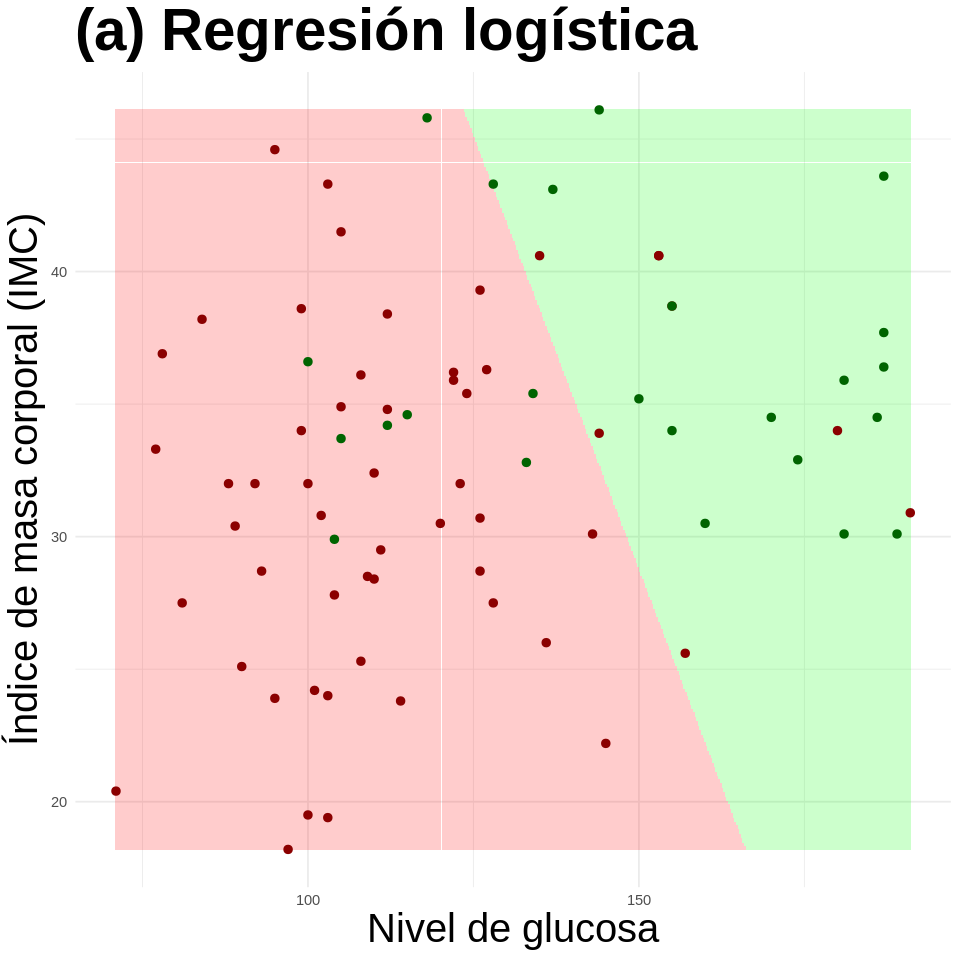

In [49]:
# Asegurar que la figura tenga suficiente espacio en Jupyter Notebook o Google Colab
options(repr.plot.width=8, repr.plot.height=8)  # Ajustar ancho y alto del gráfico

# Ampliar los rangos de la malla para incluir todos los puntos de test_data
glucose_range <- range(test_data$glucose_original)
mass_range <- range(test_data$mass_original)

grid <- expand.grid(
  glucose_original = seq(glucose_range[1], glucose_range[2], length.out = 500),
  mass_original = seq(mass_range[1], mass_range[2], length.out = 500)
)

# Escalar nuevamente las columnas glucose y mass en la malla para hacer predicciones
grid$glucose <- (grid$glucose_original - glucose_mean) / glucose_sd
grid$mass <- (grid$mass_original - mass_mean) / mass_sd

# Calcular las probabilidades para la malla
grid$prob <- predict(logistic_model, newdata = grid, type = "response")
grid$pred <- ifelse(grid$prob > 0.5, 1, 0)

# Visualizar los datos del conjunto de prueba y las regiones de decisión
ggplot() +
  # Añadir las regiones de decisión
  geom_tile(data = grid, aes(x = glucose_original, y = mass_original, fill = as.factor(pred)), alpha = 0.2) +
  # Añadir los puntos del conjunto de prueba
  geom_point(data = test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes)), size = 2) +
  # Colores para las regiones
  scale_fill_manual(
    values = c("0" = "red", "1" = "green")
  ) +
  # Colores para los puntos
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen")
  ) +
  labs(
    title = "Regresión logística",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal() +
  ggtitle("(a) Regresión logística") +
  theme(
    legend.position = "none",  # Quitar la leyenda
    plot.title = element_text(size = 35, face = "bold"), # Personalizar el título
    axis.title = element_text(size = 24)   # Personalizar títulos de los ejes
  )

Implementación modelo SVM.

In [23]:
# Fijar semilla para reproducibilidad
set.seed(61001)

# Índices para dividir los datos
train_indices <- sample(1:nrow(pima_data), 0.8 * nrow(pima_data))

# Conjuntos de entrenamiento y prueba
train_data <- pima_data[train_indices, ]
test_data <- pima_data[-train_indices, ]

# Convertir la variable diabetes a binaria en ambos conjuntos
train_data$diabetes <- ifelse(train_data$diabetes == "pos", 1, 0)
test_data$diabetes <- ifelse(test_data$diabetes == "pos", 1, 0)

# Seleccionar las columnas de interés
train_data <- train_data[, c("glucose", "mass", "diabetes")]
test_data <- test_data[, c("glucose", "mass", "diabetes")]

# Verificar los cambios
head(train_data)
head(test_data)

,glucose,mass,diabetes
,<dbl>,<dbl>,<dbl>
487,139,40.7,0
303,77,35.8,0
509,84,30.4,0
470,154,46.1,0
365,147,34.9,0
207,196,37.5,1


,glucose,mass,diabetes
,<dbl>,<dbl>,<dbl>
5,137,43.1,1
14,189,30.1,1
17,118,45.8,1
19,103,43.3,0
20,115,34.6,1
21,126,39.3,0


In [24]:
# Escalar las variables predictoras en el conjunto de entrenamiento y guardar estadísticas
glucose_scaled <- scale(train_data$glucose)
mass_scaled <- scale(train_data$mass)

# Asignar los valores escalados al conjunto de entrenamiento
train_data$glucose <- as.numeric(glucose_scaled)
train_data$mass <- as.numeric(mass_scaled)

# Guardar las estadísticas de escalado
glucose_mean <- attr(glucose_scaled, "scaled:center")
glucose_sd <- attr(glucose_scaled, "scaled:scale")
mass_mean <- attr(mass_scaled, "scaled:center")
mass_sd <- attr(mass_scaled, "scaled:scale")

# Escalar las mismas columnas en el conjunto de prueba usando las estadísticas del entrenamiento
test_data$glucose <- as.numeric((test_data$glucose - glucose_mean) / glucose_sd)
test_data$mass <- as.numeric((test_data$mass - mass_mean) / mass_sd)

# Verificar los cambios
head(train_data)
head(test_data)

,glucose,mass,diabetes
,<dbl>,<dbl>,<dbl>
487,0.5515935,1.0532713,0
303,-1.4631296,0.3725287,0
509,-1.2356609,-0.3776774,0
470,1.0390266,1.8034775,0
365,0.8115578,0.2474943,0
207,2.4038390,0.6087047,1


,glucose,mass,diabetes
,<dbl>,<dbl>,<dbl>
5,0.4866025,1.3866963,1
14,2.1763703,-0.4193556,1
17,-0.1308127,1.7617993,1
19,-0.6182457,1.4144817,0
20,-0.2282993,0.2058162,1
21,0.1291516,0.8587734,0


In [25]:
# Cargar librería necesaria
if (!requireNamespace("e1071", quietly = TRUE)) {
  install.packages("e1071")
}
library(e1071)

# Ajustar el modelo SVM como clasificador
svm_model <- svm(
  diabetes ~ glucose + mass,
  data = train_data,
  type = "C-classification",  # Especificar clasificación
  kernel = "linear",
  probability = TRUE
)

# Verificar si el modelo se entrenó correctamente
if (!is.null(svm_model)) {
  cat("Modelo SVM entrenado con éxito.\n")
} else {
  stop("Error: El modelo SVM no se entrenó correctamente.")
}

# Realizar predicciones con probabilidades
svm_predictions <- predict(svm_model, newdata = test_data, probability = TRUE)

# Guardar las probabilidades en una variable separada
svm_probabilities <- attr(svm_predictions, "probabilities")[, "1"]  # Probabilidad para clase "1"

# Convertir las probabilidades a clases predichas (0 o 1)
svm_predicted_classes <- ifelse(svm_probabilities > 0.5, 1, 0)

# Calcular la precisión
svm_accuracy <- mean(test_data$diabetes == svm_predicted_classes)
accuracy_svm <- svm_accuracy
cat("Precisión del modelo SVM en el conjunto de prueba:", round(svm_accuracy * 100, 2), "%\n")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




Modelo SVM entrenado con éxito.
Precisión del modelo SVM en el conjunto de prueba: 78.48 %


In [26]:
# Crear una malla ajustada al rango de los datos en test_data
grid <- expand.grid(
  glucose = seq(min(train_data$glucose), max(train_data$glucose), length.out = 500),  # Más puntos para suavizar
  mass = seq(min(train_data$mass), max(train_data$mass), length.out = 500)           # Ajustar a los datos
)

# Predecir las clases para la malla
svm_grid_predictions <- predict(svm_model, newdata = grid, probability = TRUE)
grid$svm_decision <- as.numeric(svm_grid_predictions) - 1  # Convertir predicciones a clases binarias (0 y 1)

# Desescalar las columnas glucose y mass en el conjunto de prueba y la malla
test_data$glucose_original <- (test_data$glucose * glucose_sd) + glucose_mean
test_data$mass_original <- (test_data$mass * mass_sd) + mass_mean

grid$glucose_original <- (grid$glucose * glucose_sd) + glucose_mean
grid$mass_original <- (grid$mass * mass_sd) + mass_mean

# Limitar la malla al rango de los puntos en test_data
grid <- grid[
  grid$glucose_original >= min(test_data$glucose_original) &
  grid$glucose_original <= max(test_data$glucose_original) &
  grid$mass_original >= min(test_data$mass_original) &
  grid$mass_original <= max(test_data$mass_original),
]

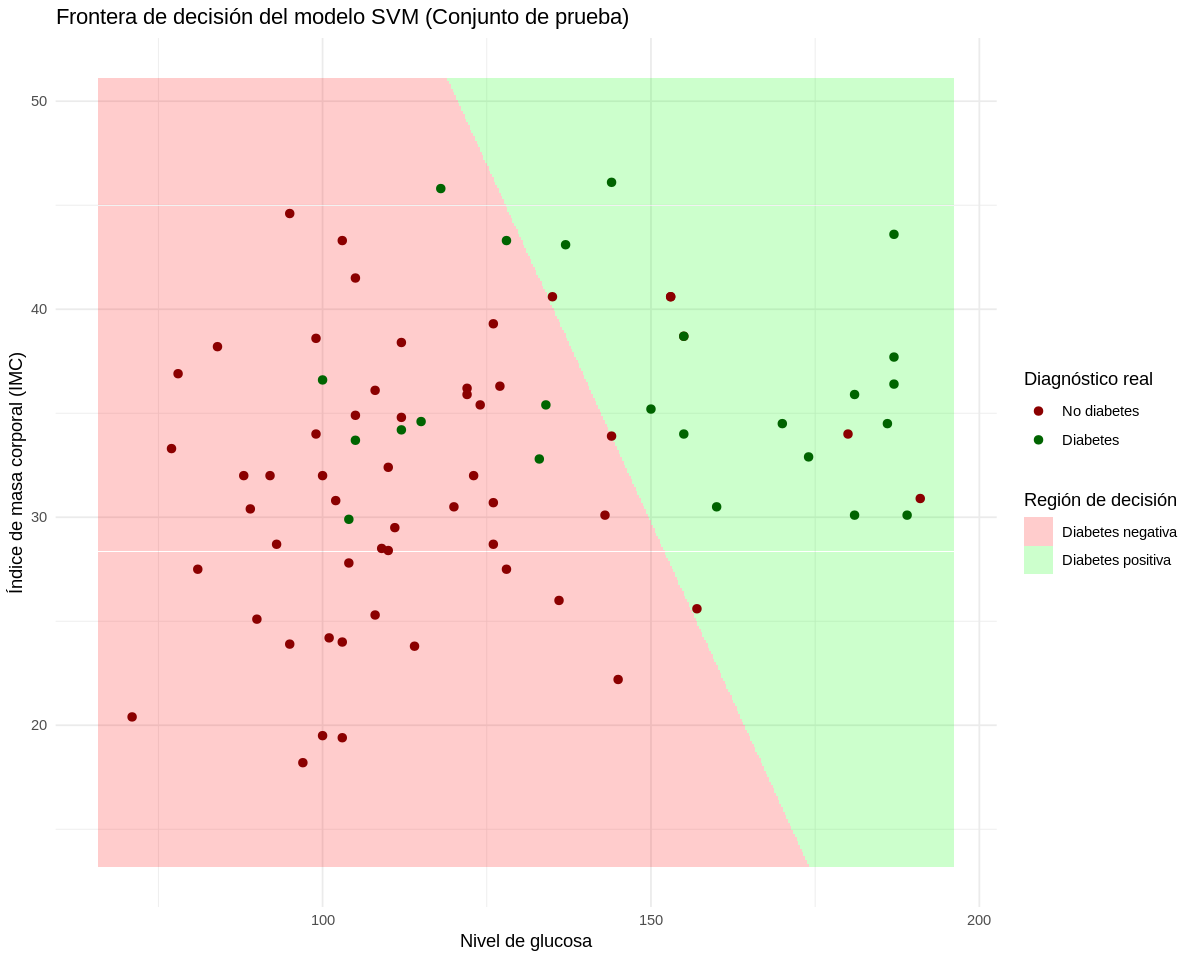

In [27]:
# Ampliar la malla para incluir un margen adicional
glucose_range <- range(test_data$glucose_original)
mass_range <- range(test_data$mass_original)

grid <- expand.grid(
  glucose_original = seq(glucose_range[1] - 5, glucose_range[2] + 5, length.out = 500),
  mass_original = seq(mass_range[1] - 5, mass_range[2] + 5, length.out = 500)
)

# Escalar nuevamente las columnas glucose y mass en la malla para hacer predicciones
grid$glucose <- (grid$glucose_original - glucose_mean) / glucose_sd
grid$mass <- (grid$mass_original - mass_mean) / mass_sd

# Predecir las clases para la malla
svm_grid_predictions <- predict(svm_model, newdata = grid, probability = TRUE)
grid$svm_decision <- as.numeric(svm_grid_predictions) - 1

# Graficar las regiones actualizadas
ggplot() +
  geom_tile(data = grid, aes(x = glucose_original, y = mass_original, fill = as.factor(svm_decision)), alpha = 0.2) +
  geom_point(data = test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes)), size = 2) +
  #geom_contour(data = grid, aes(x = glucose_original, y = mass_original, z = svm_decision), breaks = 0.5, color = "black", linewidth = 1.2) +
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diabetes negativa", "1" = "Diabetes positiva"),
    name = "Región de decisión"
  ) +
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  labs(
    title = "Frontera de decisión del modelo SVM (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal()

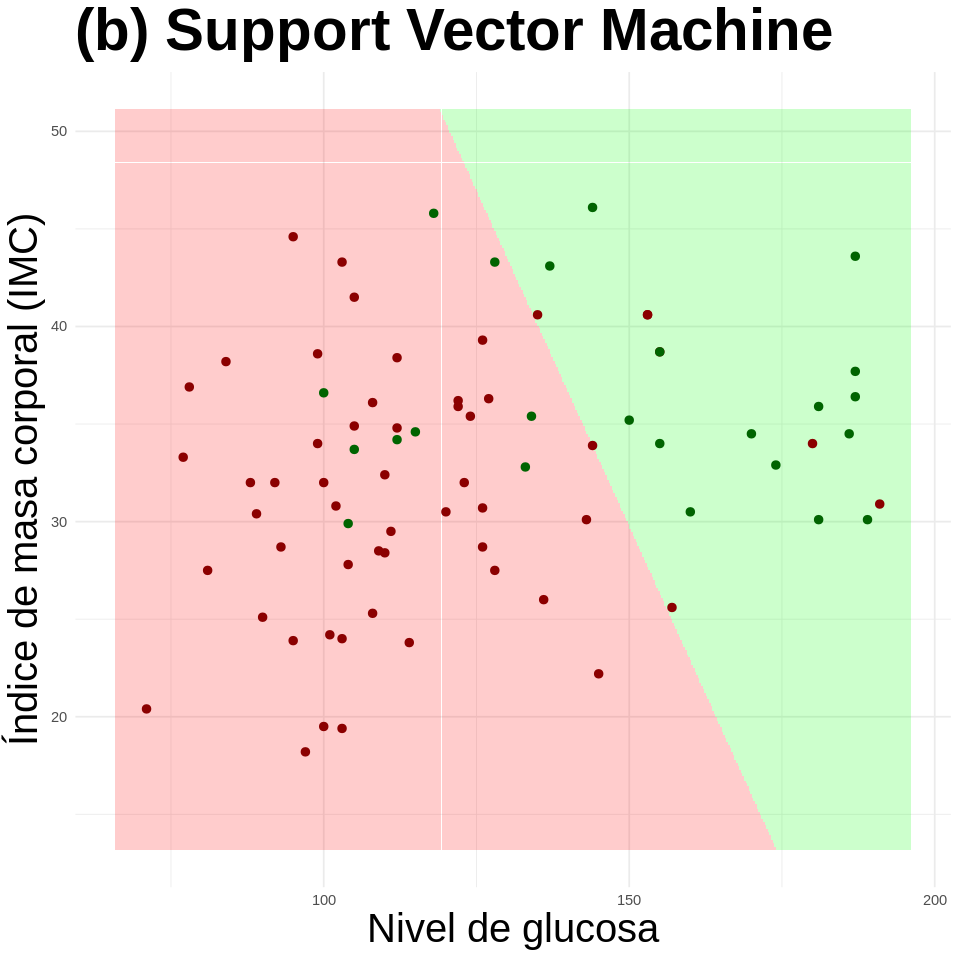

In [52]:
# Asegurar que la figura tenga suficiente espacio en Jupyter Notebook o Google Colab
options(repr.plot.width=8, repr.plot.height=8)  # Ajustar ancho y alto del gráfico

# Ampliar la malla para incluir un margen adicional
glucose_range <- range(test_data$glucose_original)
mass_range <- range(test_data$mass_original)

grid <- expand.grid(
  glucose_original = seq(glucose_range[1] - 5, glucose_range[2] + 5, length.out = 500),
  mass_original = seq(mass_range[1] - 5, mass_range[2] + 5, length.out = 500)
)

# Escalar nuevamente las columnas glucose y mass en la malla para hacer predicciones
grid$glucose <- (grid$glucose_original - glucose_mean) / glucose_sd
grid$mass <- (grid$mass_original - mass_mean) / mass_sd

# Predecir las clases para la malla
svm_grid_predictions <- predict(svm_model, newdata = grid, probability = TRUE)
grid$svm_decision <- as.numeric(svm_grid_predictions) - 1

# Graficar las regiones actualizadas
ggplot() +
  geom_tile(data = grid, aes(x = glucose_original, y = mass_original, fill = as.factor(svm_decision)), alpha = 0.2) +
  geom_point(data = test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes)), size = 2) +
  #geom_contour(data = grid, aes(x = glucose_original, y = mass_original, z = svm_decision), breaks = 0.5, color = "black", linewidth = 1.2) +
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diabetes negativa", "1" = "Diabetes positiva"),
    name = "Región de decisión"
  ) +
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  labs(
    title = "Frontera de decisión del modelo SVM (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal() +
  ggtitle("(b) Support Vector Machine") +
  theme(
    legend.position = "none",  # Quitar la leyenda
    plot.title = element_text(size = 35, face = "bold"), # Personalizar el título
    axis.title = element_text(size = 24)   # Personalizar títulos de los ejes
  )

Implementación del perceptrón.

In [29]:
# Inicialización del perceptrón
initialize_weights <- function(n_features) {
  weights <- rep(0, n_features)
  bias <- 0
  list(weights = weights, bias = bias)
}

# Función de predicción del perceptrón
predict_perceptron <- function(x, weights, bias) {
  z <- sum(weights * x) + bias
  ifelse(z >= 0, 1, 0)
}

# Función para entrenar el perceptrón
train_perceptron <- function(train_data, labels, lr = 0.01, epochs = 100) {
  n_features <- ncol(train_data)
  params <- initialize_weights(n_features)
  weights <- params$weights
  bias <- params$bias

  for (epoch in 1:epochs) {
    for (i in 1:nrow(train_data)) {
      x <- as.numeric(train_data[i, ])
      y <- labels[i]
      y_pred <- predict_perceptron(x, weights, bias)

      # Actualización de pesos y sesgo si hay error
      error <- y - y_pred
      weights <- weights + lr * error * x
      bias <- bias + lr * error
    }
  }

  list(weights = weights, bias = bias)
}

# Preparar los datos de entrenamiento
X_train <- as.matrix(train_data[, c("glucose", "mass")])  # Variables predictoras
y_train <- train_data$diabetes  # Etiquetas

# Entrenar el perceptrón
perceptron_model <- train_perceptron(X_train, y_train, lr = 0.1, epochs = 1000)
weights <- perceptron_model$weights
bias <- perceptron_model$bias

# Predicción en el conjunto de prueba
X_test <- as.matrix(test_data[, c("glucose", "mass")])
test_data$predicted_perceptron <- apply(X_test, 1, function(x) predict_perceptron(x, weights, bias))

# Calcular la precisión del modelo
correct_predictions <- sum(test_data$predicted_perceptron == test_data$diabetes)
total_predictions <- nrow(test_data)
precision <- correct_predictions / total_predictions
accuracy_perceptron <- precision

cat("Precisión del modelo:", precision*100, "\n")

Precisión del modelo: 79.74684 


In [30]:
weights
bias

[1] 0.1821411 0.1102673

[1] -0.2

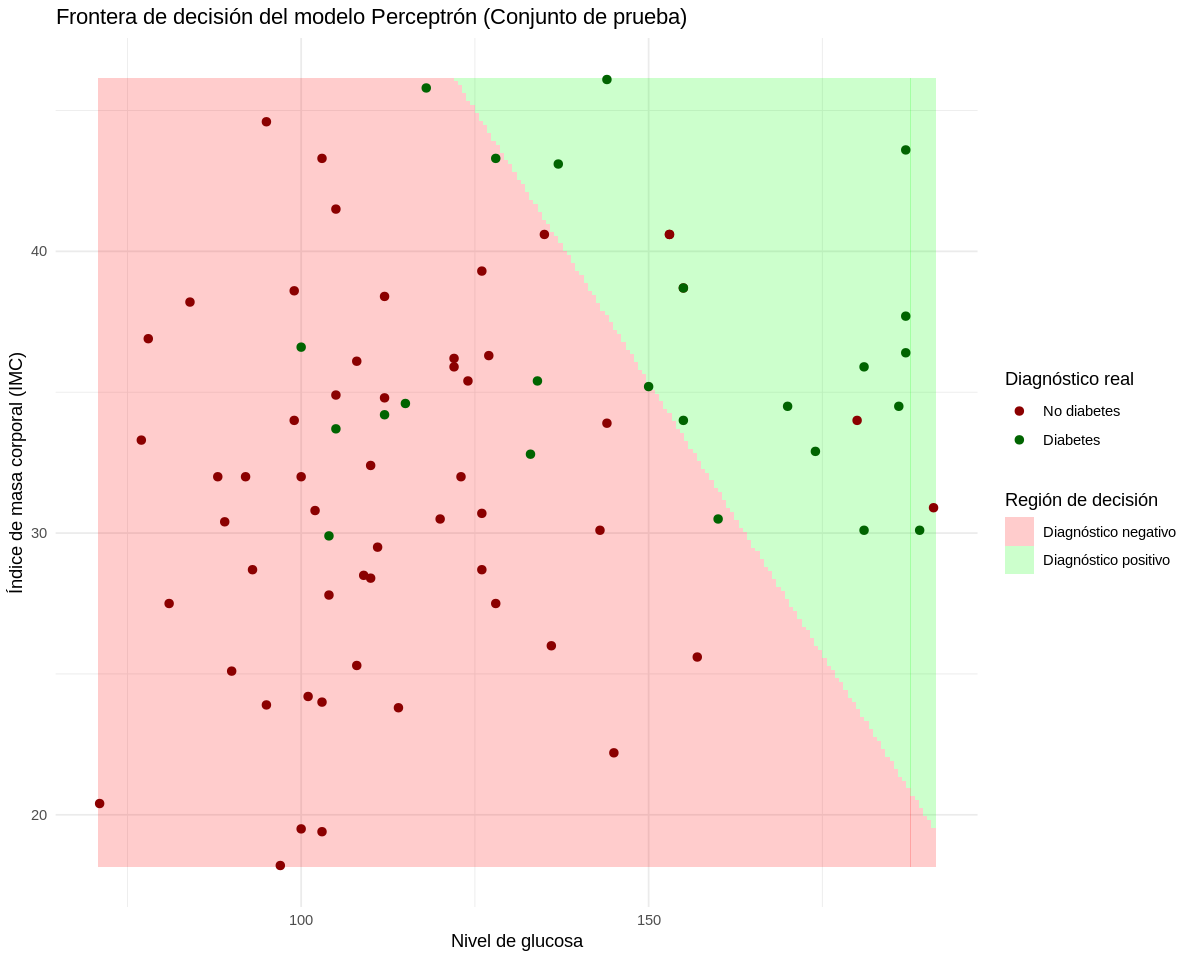

In [31]:
library(ggplot2)

# Crear la frontera de decisión para la región de colores
decision_boundary_data <- expand.grid(
  glucose = seq(min(test_data$glucose), max(test_data$glucose), length.out = 200),
  mass = seq(min(test_data$mass), max(test_data$mass), length.out = 200)
)

decision_boundary_data$predicted <- apply(
  decision_boundary_data[, c("glucose", "mass")],
  1,
  function(x) predict_perceptron(x, weights, bias)
)

# Desescalar las variables para que los ejes se muestren correctamente
decision_boundary_data$glucose_original <- (decision_boundary_data$glucose * glucose_sd) + glucose_mean
decision_boundary_data$mass_original <- (decision_boundary_data$mass * mass_sd) + mass_mean

test_data$glucose_original <- (test_data$glucose * glucose_sd) + glucose_mean
test_data$mass_original <- (test_data$mass * mass_sd) + mass_mean

# Gráfico con regiones coloreadas y puntos
ggplot() +
  geom_tile(data = decision_boundary_data, aes(
    x = glucose_original,
    y = mass_original,
    fill = as.factor(predicted)
  ), alpha = 0.2) +  # Regiones de decisión
  geom_point(data = test_data, aes(
    x = glucose_original,
    y = mass_original,
    color = as.factor(diabetes)
  ), size = 2) +  # Puntos del conjunto de prueba
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diagnóstico negativo", "1" = "Diagnóstico positivo"),
    name = "Región de decisión"
  ) +
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  labs(
    title = "Frontera de decisión del modelo Perceptrón (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal()

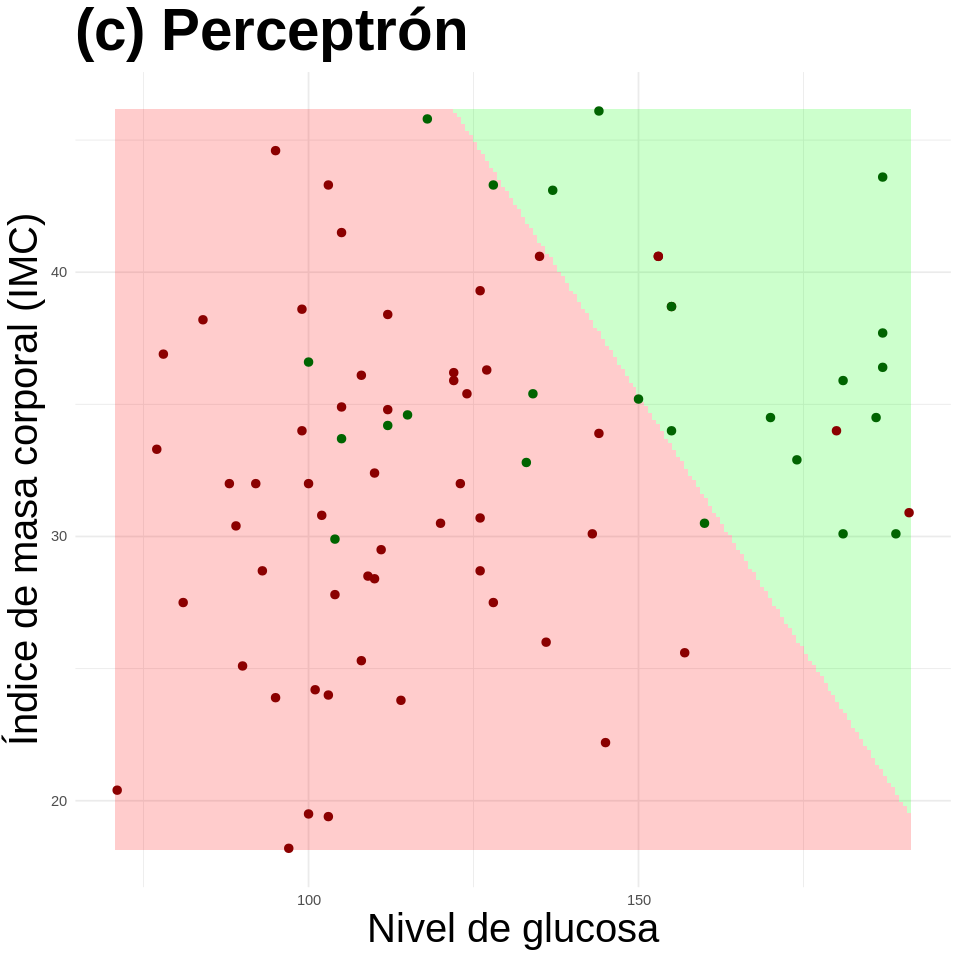

In [54]:
# Asegurar que la figura tenga suficiente espacio en Jupyter Notebook o Google Colab
options(repr.plot.width=8, repr.plot.height=8)  # Ajustar ancho y alto del gráfico

ggplot() +
  geom_tile(data = decision_boundary_data, aes(
    x = glucose_original,
    y = mass_original,
    fill = as.factor(predicted)
  ), alpha = 0.2) +  # Regiones de decisión
  geom_point(data = test_data, aes(
    x = glucose_original,
    y = mass_original,
    color = as.factor(diabetes)
  ), size = 2) +  # Puntos del conjunto de prueba
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diagnóstico negativo", "1" = "Diagnóstico positivo"),
    name = "Región de decisión"
  ) +
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  labs(
    title = "Frontera de decisión del modelo Perceptrón (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (IMC)"
  ) +
  theme_minimal() +
  ggtitle("(c) Perceptrón") +
  theme(
    legend.position = "none",  # Quitar la leyenda
    plot.title = element_text(size = 35, face = "bold"), # Personalizar el título
    axis.title = element_text(size = 24)   # Personalizar títulos de los ejes
  )

In [33]:
# Crear la tabla
accuracy_table <- data.frame(
  Modelo = c("Regresión Logística", "SVM", "Perceptrón"),
  Accuracy = c(accuracy_logistic, accuracy_svm, accuracy_perceptron)
)

# Mostrar la tabla
print(accuracy_table)

               Modelo  Accuracy
1 Regresión Logística 0.7974684
2                 SVM 0.7848101
3          Perceptrón 0.7974684


En lo que sigue no es realmente un perceptrón, sino una red neuronal con una capa oculta.

In [34]:
# 1. Instalar y cargar las librerías necesarias
if (!requireNamespace("nnet", quietly = TRUE)) {
  install.packages("nnet")
}
library(nnet)
library(ggplot2)

# 2. Convertir la variable objetivo (diabetes) a factor
train_data$diabetes <- as.factor(train_data$diabetes)
test_data$diabetes <- as.factor(test_data$diabetes)

# 3. Escalar las variables predictoras en los conjuntos de entrenamiento y prueba
train_data$glucose <- as.numeric(scale(train_data$glucose))
train_data$mass <- as.numeric(scale(train_data$mass))

# Guardar las estadísticas de escalado para aplicarlas al conjunto de prueba
glucose_mean <- attr(scale(train_data$glucose), "scaled:center")
glucose_sd <- attr(scale(train_data$glucose), "scaled:scale")
mass_mean <- attr(scale(train_data$mass), "scaled:center")
mass_sd <- attr(scale(train_data$mass), "scaled:scale")

# Aplicar el mismo escalado al conjunto de prueba
test_data$glucose <- as.numeric((test_data$glucose - glucose_mean) / glucose_sd)
test_data$mass <- as.numeric((test_data$mass - mass_mean) / mass_sd)

# 4. Entrenar el modelo de perceptrón con una capa oculta
set.seed(61001)  # Asegurar reproducibilidad
perceptron_model <- nnet(diabetes ~ glucose + mass,
                         data = train_data,
                         size = 1,           # Una capa oculta con un nodo
                         maxit = 200,        # Número máximo de iteraciones
                         linout = FALSE)     # Clasificación, no regresión

# 5. Resumen del modelo
cat("Resumen del modelo de perceptrón:\n")
summary(perceptron_model)


# 6. Verificar tipos de datos en test_data antes de predecir
str(test_data)  # Asegurar que glucose y mass son numéricas

# 7. Predicciones en el conjunto de prueba
test_data$perceptron_pred <- predict(perceptron_model, newdata = test_data, type = "class")

# 8. Calcular precisión del modelo en el conjunto de prueba
perceptron_accuracy <- mean(test_data$diabetes == test_data$perceptron_pred)
cat("Precisión del modelo de perceptrón en el conjunto de prueba:", round(perceptron_accuracy * 100, 2), "%\n")

# weights:  5
initial  value 207.985861 
iter  10 value 152.680824
iter  20 value 149.909272
iter  30 value 149.665599
final  value 149.663011 
converged
Resumen del modelo de perceptrón:


a 2-1-1 network with 5 weights
options were - entropy fitting 
 b->h1 i1->h1 i2->h1 
 -0.43  -0.89  -0.39 
 b->o h1->o 
 2.02 -7.13 

'data.frame':	79 obs. of  6 variables:
 $ glucose             : num  0.487 2.176 -0.131 -0.618 -0.228 ...
 $ mass                : num  1.387 -0.419 1.762 1.414 0.206 ...
 $ diabetes            : Factor w/ 2 levels "0","1": 2 2 2 1 2 1 1 1 1 1 ...
 $ glucose_original    : num  137 189 118 103 115 126 145 103 180 103 ...
 $ mass_original       : num  43.1 30.1 45.8 43.3 34.6 39.3 22.2 24 34 19.4 ...
 $ predicted_perceptron: num  1 1 0 0 0 0 0 0 1 0 ...
Precisión del modelo de perceptrón en el conjunto de prueba: 81.01 %


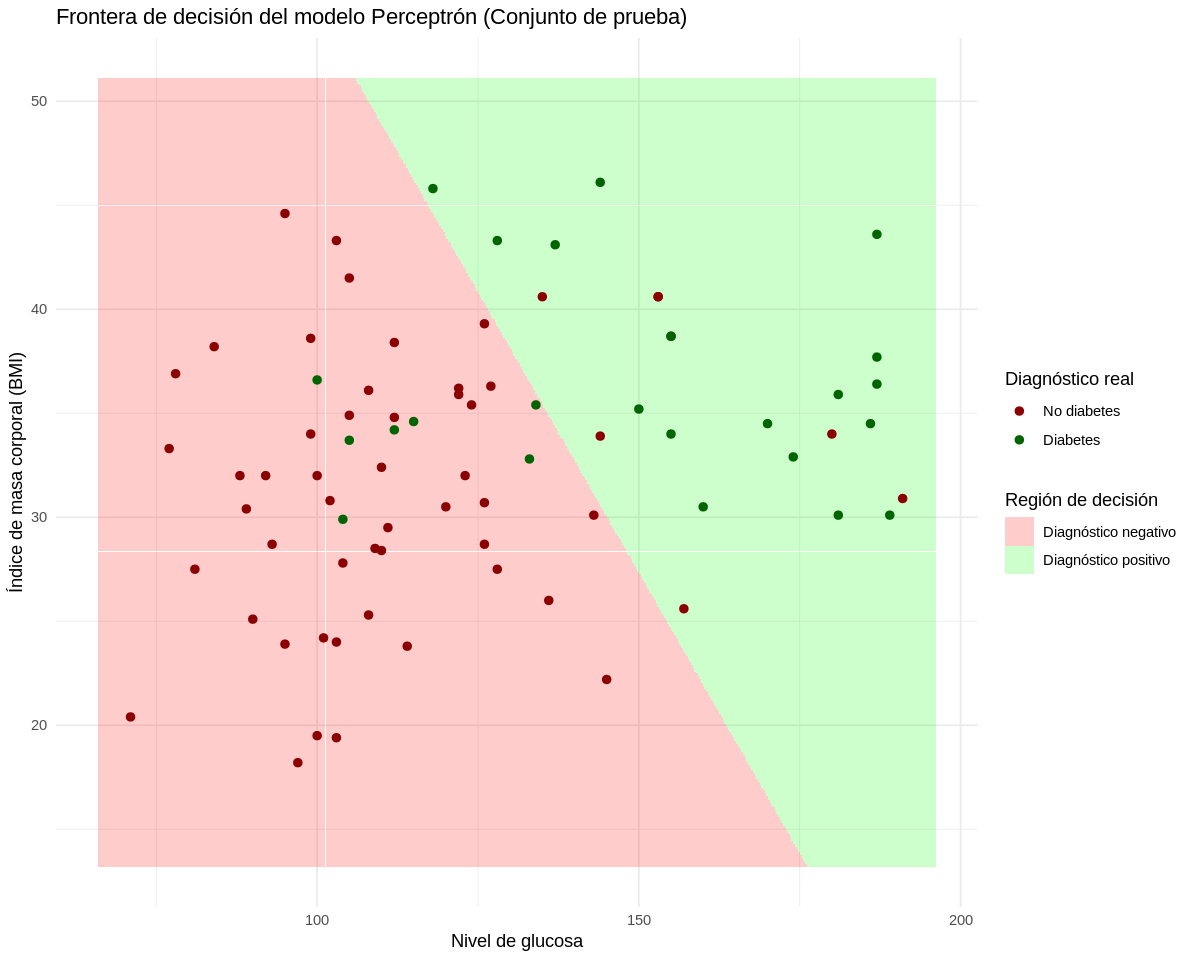

In [35]:
# Fijar semilla para reproducibilidad
set.seed(61001)

# Índices para dividir los datos
train_indices <- sample(1:nrow(pima_data), 0.8 * nrow(pima_data))

# Conjuntos de entrenamiento y prueba
train_data <- pima_data[train_indices, ]
test_data <- pima_data[-train_indices, ]

# Convertir la variable diabetes a binaria en ambos conjuntos
train_data$diabetes <- ifelse(train_data$diabetes == "pos", 1, 0)
test_data$diabetes <- ifelse(test_data$diabetes == "pos", 1, 0)

# Seleccionar las columnas de interés
train_data <- train_data[, c("glucose", "mass", "diabetes")]
test_data <- test_data[, c("glucose", "mass", "diabetes")]

# Guardar los valores originales (sin escalar)
train_data$glucose_original <- train_data$glucose
train_data$mass_original <- train_data$mass
test_data$glucose_original <- test_data$glucose
test_data$mass_original <- test_data$mass

# Escalar las variables predictoras en el conjunto de entrenamiento y guardar estadísticas
glucose_scaled <- scale(train_data$glucose)
mass_scaled <- scale(train_data$mass)

# Asignar los valores escalados al conjunto de entrenamiento
train_data$glucose <- as.numeric(glucose_scaled)
train_data$mass <- as.numeric(mass_scaled)

# Guardar las estadísticas de escalado
glucose_mean <- attr(glucose_scaled, "scaled:center")
glucose_sd <- attr(glucose_scaled, "scaled:scale")
mass_mean <- attr(mass_scaled, "scaled:center")
mass_sd <- attr(mass_scaled, "scaled:scale")

# Escalar las mismas columnas en el conjunto de prueba usando las estadísticas del entrenamiento
test_data$glucose <- as.numeric((test_data$glucose - glucose_mean) / glucose_sd)
test_data$mass <- as.numeric((test_data$mass - mass_mean) / mass_sd)

# Crear una malla para graficar la línea de decisión
glucose_range <- range(test_data$glucose_original)
mass_range <- range(test_data$mass_original)

grid <- expand.grid(
  glucose_original = seq(glucose_range[1] - 5, glucose_range[2] + 5, length.out = 500),
  mass_original = seq(mass_range[1] - 5, mass_range[2] + 5, length.out = 500)
)

# Escalar nuevamente las columnas glucose y mass en la malla para hacer predicciones
grid$glucose <- (grid$glucose_original - glucose_mean) / glucose_sd
grid$mass <- (grid$mass_original - mass_mean) / mass_sd

# Predecir clases en la malla con el modelo Perceptrón
grid$perceptron_pred <- predict(perceptron_model, newdata = grid, type = "class")

# Visualizar resultados con las variables originales
ggplot() +
  # Dibujar las regiones de decisión
  geom_tile(data = grid, aes(x = glucose_original, y = mass_original, fill = as.factor(perceptron_pred)), alpha = 0.2) +
  # Dibujar los puntos del conjunto de prueba
  geom_point(data = test_data, aes(x = glucose_original, y = mass_original, color = as.factor(diabetes)), size = 2) +
  # Añadir la frontera de decisión
  #geom_contour(data = grid, aes(x = glucose_original, y = mass_original, z = as.numeric(perceptron_pred)),
              # breaks = 0.5, color = "black", linewidth = 1.2) +
  # Definir los colores para las regiones
  scale_fill_manual(
    values = c("0" = "red", "1" = "green"),
    labels = c("0" = "Diagnóstico negativo", "1" = "Diagnóstico positivo"),
    name = "Región de decisión"
  ) +
  # Definir los colores para los puntos
  scale_color_manual(
    values = c("0" = "darkred", "1" = "darkgreen"),
    labels = c("0" = "No diabetes", "1" = "Diabetes"),
    name = "Diagnóstico real"
  ) +
  # Etiquetas y tema del gráfico
  labs(
    title = "Frontera de decisión del modelo Perceptrón (Conjunto de prueba)",
    x = "Nivel de glucosa",
    y = "Índice de masa corporal (BMI)"
  ) +
  theme_minimal()

In [36]:
# Fijar semilla para reproducibilidad
set.seed(61001)

# Índices para dividir los datos
train_indices <- sample(1:nrow(pima_data), 0.8 * nrow(pima_data))

# Conjuntos de entrenamiento y prueba
train_data <- pima_data[train_indices, ]
test_data <- pima_data[-train_indices, ]


# Convertir la variable diabetes a binaria en ambos conjuntos
train_data$diabetes <- ifelse(train_data$diabetes == "pos", 1, 0)
test_data$diabetes <- ifelse(test_data$diabetes == "pos", 1, 0)

# Escalar las variables predictoras en el conjunto de entrenamiento y guardar estadísticas
glucose_scaled <- scale(train_data$glucose)
mass_scaled <- scale(train_data$mass)

# Asignar los valores escalados al conjunto de entrenamiento
train_data$glucose <- as.numeric(glucose_scaled)
train_data$mass <- as.numeric(mass_scaled)

# Guardar las estadísticas de escalado
glucose_mean <- attr(glucose_scaled, "scaled:center")
glucose_sd <- attr(glucose_scaled, "scaled:scale")
mass_mean <- attr(mass_scaled, "scaled:center")
mass_sd <- attr(mass_scaled, "scaled:scale")

# Escalar las mismas columnas en el conjunto de prueba usando las estadísticas del entrenamiento
test_data$glucose <- as.numeric((test_data$glucose - glucose_mean) / glucose_sd)
test_data$mass <- as.numeric((test_data$mass - mass_mean) / mass_sd)

# Verificar los cambios
head(train_data)
head(test_data)

,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
487,0.5515935,1.0532713,0,1
303,-1.4631296,0.3725287,0,2
509,-1.2356609,-0.3776774,0,2
470,1.0390266,1.8034775,0,1
365,0.8115578,0.2474943,0,1
207,2.4038390,0.6087047,1,1


,glucose,mass,diabetes,Cluster
,<dbl>,<dbl>,<dbl>,<fct>
5,0.4866025,1.3866963,1,1
14,2.1763703,-0.4193556,1,1
17,-0.1308127,1.7617993,1,1
19,-0.6182457,1.4144817,0,2
20,-0.2282993,0.2058162,1,2
21,0.1291516,0.8587734,0,1


In [37]:
# Ajustar el modelo de regresión logística en el conjunto de entrenamiento
logistic_model <- glm(diabetes ~ glucose + mass, data = train_data, family = binomial)

# Resumen del modelo (coeficientes y significancia)
cat("Resumen del modelo de regresión logística:\n")
summary(logistic_model)

# Predicciones en el conjunto de prueba
test_data$prob_logistic <- predict(logistic_model, newdata = test_data, type = "response")  # Probabilidades predichas
test_data$pred_logistic <- ifelse(test_data$prob > 0.5, 1, 0)                              # Clasificación basada en 0.5

# Calcular precisión del modelo en el conjunto de prueba
accuracy <- mean(test_data$diabetes == test_data$pred)
cat("Precisión del modelo en el conjunto de prueba:", round(accuracy * 100, 2), "%\n")

Resumen del modelo de regresión logística:



Call:
glm(formula = diabetes ~ glucose + mass, family = binomial, data = train_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.8803     0.1479  -5.950 2.67e-09 ***
glucose       1.2698     0.1677   7.571 3.71e-14 ***
mass          0.4540     0.1509   3.008  0.00263 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 400.73  on 312  degrees of freedom
Residual deviance: 301.35  on 310  degrees of freedom
AIC: 307.35

Number of Fisher Scoring iterations: 4


Precisión del modelo en el conjunto de prueba: 79.75 %


In [38]:
test_data

,glucose,mass,diabetes,Cluster,prob_logistic,pred_logistic
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5,0.48660247,1.38669627,1,1,0.59076609,1
14,2.17637029,-0.41935556,1,1,0.84460250,1
17,-0.13081270,1.76179934,1,1,0.43866945,0
19,-0.61824572,1.41448168,0,2,0.26441108,0
20,-0.22829930,0.20581623,1,2,0.25412852,0
21,0.12915158,0.85877343,0,1,0.41911455,0
29,0.74656675,-1.51687936,0,2,0.34957834,0
36,-0.61824572,-1.26681065,0,2,0.09618241,0
41,1.88391047,0.12245999,0,1,0.82742493,1


In [39]:
# Cargar librería necesaria
if (!requireNamespace("e1071", quietly = TRUE)) {
  install.packages("e1071")
}
library(e1071)

#Ajustar el modelo SVM como clasificador
svm_model <- svm(
  diabetes ~ glucose + mass,
  data = train_data[, c("glucose", "mass","diabetes")],
  type = "C-classification",  # Especificar clasificación
  kernel = "linear",
  probability = TRUE
)

# Verificar si el modelo se entrenó correctamente
if (!is.null(svm_model)) {
  cat("Modelo SVM entrenado con éxito.\n")
} else {
  stop("Error: El modelo SVM no se entrenó correctamente.")
}

# Realizar predicciones con probabilidades
svm_predictions <- predict(svm_model, newdata = test_data[, c("glucose", "mass","diabetes")], probability = TRUE)

# Guardar las probabilidades en una variable separada
svm_probabilities <- attr(svm_predictions, "probabilities")[, "1"]  # Probabilidad para clase "1"

# Convertir las probabilidades a clases predichas (0 o 1)
svm_predicted_classes <- ifelse(svm_probabilities > 0.5, 1, 0)

# Calcular la precisión
svm_accuracy <- mean(test_data$diabetes == svm_predicted_classes)
cat("Precisión del modelo SVM en el conjunto de prueba:", round(svm_accuracy * 100, 2), "%\n")

Modelo SVM entrenado con éxito.
Precisión del modelo SVM en el conjunto de prueba: 78.48 %
